### Importing the necessary packages

In [1]:
import numpy as np #linear algebra
import pandas as pd #reading, preprocessing and writing data

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# Text cleaning
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning Models
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Miscelleneous
from collections import Counter
import joblib
import scipy.sparse
import tensorflow as tf

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print("Shape of training set:", train.shape)
print("Shape of testing set:", test.shape)

Shape of training set: (7613, 5)
Shape of testing set: (3263, 4)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Exploratory Data Analysis

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
print("Shape of training dataset: ", train.shape)
print("Shape of testing dataset: ", test.shape)

Shape of training dataset:  (7613, 5)
Shape of testing dataset:  (3263, 4)


In [11]:
df = pd.concat([train, test], axis=0)

In [12]:
wnl = WordNetLemmatizer()

In [13]:
df['text'].replace(r'https?://t.co/[0-9a-zA-Z]*', "", inplace=True, regex=True)
df['text'].replace(r'\.', "", inplace=True, regex=True)
df['text'].replace('#', "", inplace=True, regex=True)
df['text'].replace(r'\?*', "", inplace=True, regex=True)
df['text'].replace(r"\'", "", inplace=True, regex=True)
df['text'].replace(r"\:", " ", inplace=True, regex=True)
df['text'] = df['text'].str.lower()
df['text'].replace('%20', " ", inplace=True, regex=True)
df['text'].replace(r"-", "", inplace=True, regex=True)
df['text'].replace(r'[^\d\w\s]', '', inplace=True, regex=True)
df['text'].replace(r'@', '', inplace=True, regex=True)

In [14]:
keyw = set([key for key in df['keyword'] if pd.notnull(key)])
keyword_set = []
for k in keyw:
    if ('%20' in k):
        for k_sp in k.split('%20'):
            keyword_set.append(k_sp)
    else:
        keyword_set.append(k)

In [15]:
def keyword_fill(col):
    keyword = col[0]
    text = col[1]
    global keyword_set
    if pd.isnull(keyword):
        key_wrd = [wnl.lemmatize(k) for k in keyword_set]
        for key in key_wrd:
            if (key not in wnl.lemmatize(text)):
                continue
            return key
            
    elif '%20' in keyword:
        return keyword.split('%20')[-1]
    
    else:
        return keyword

In [16]:
df['keyword'] = df[['keyword', 'text']].apply(keyword_fill, axis=1)

In [17]:
df['keyword'].fillna("nil", inplace=True)

In [18]:
df.head()

,id,keyword,location,text,target
0,1,on,NaN,our deeds are the reason of this earthquake ma...,1.0
1,4,fire,NaN,forest fire near la ronge sask canada,1.0
2,5,on,NaN,all residents asked to shelter in place are be...,1.0
3,6,fire,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,fire,NaN,just got sent this photo from ruby alaska as s...,1.0


In [19]:
text  = [t for t in df['text'] if "#" in t]

In [20]:
df.isnull().sum()

id             0
keyword        0
location    3638
text           0
target      3263
dtype: int64

In [21]:
train = df[pd.notnull(df['target'])]
test = df[pd.isnull(df['target'])]

In [22]:
keywords_count = pd.DataFrame({'count': train['keyword'].value_counts()})

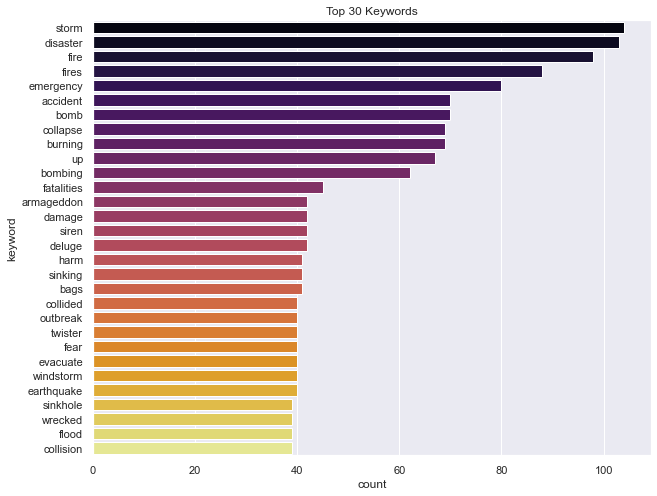

In [23]:
plt.figure(figsize=(10,8))
sns.countplot(y='keyword', data=train, 
              order=pd.value_counts(train['keyword']).iloc[:30].index, palette='inferno')
plt.title("Top 30 Keywords")
plt.show()

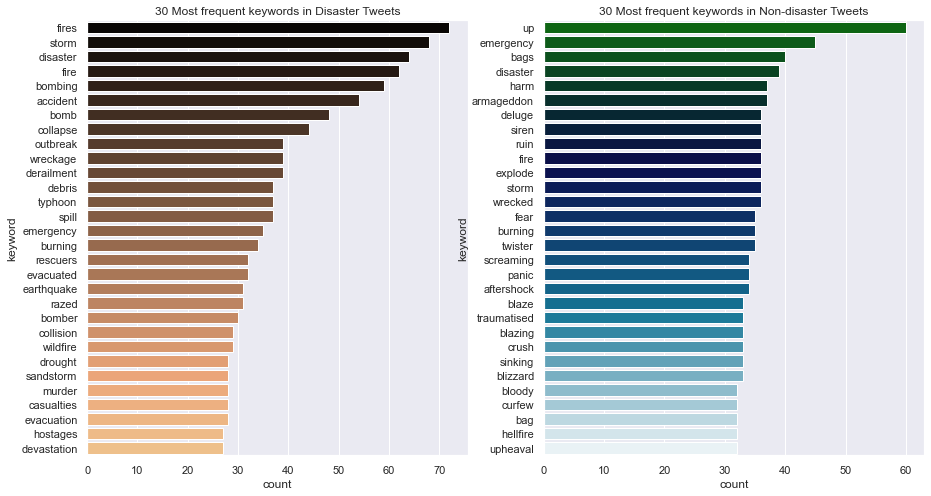

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].set_title("30 Most frequent keywords in Disaster Tweets")
sns.countplot(y=train[train['target']==1]['keyword'],
              ax=ax[0], palette='copper',
              order=pd.value_counts(train[train['target']==1]['keyword']).iloc[:30].index)

ax[1].set_title("30 Most frequent keywords in Non-disaster Tweets")
sns.countplot(y='keyword', data=train[train['target']==0],
              ax=ax[1], palette='ocean',
              order=pd.value_counts(train[train['target']==0]['keyword']).iloc[:30].index)
plt.show()

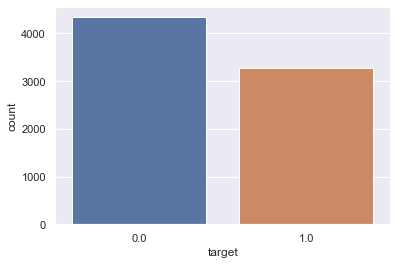

In [25]:
sns.countplot(train['target']);

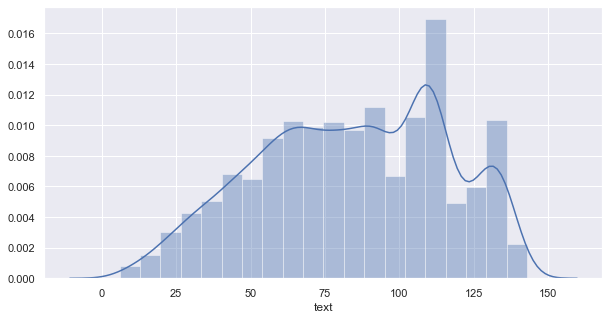

In [26]:
plt.figure(figsize=(10,5))
sns.distplot(train['text'].apply(len), bins=20);

In [27]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if w not in stop_words]
    filtered = ' '.join(filtered)
    return filtered

In [28]:
df['cleaned_text'] = df['text'].apply(remove_stopwords)

In [29]:
df[df['text'] == df['cleaned_text']].shape

(176, 6)

In [30]:
df.head()

,id,keyword,location,text,target,cleaned_text
0,1,on,NaN,our deeds are the reason of this earthquake ma...,1.0,deeds reason earthquake may allah forgive us
1,4,fire,NaN,forest fire near la ronge sask canada,1.0,forest fire near la ronge sask canada
2,5,on,NaN,all residents asked to shelter in place are be...,1.0,residents asked shelter place notified officer...
3,6,fire,NaN,13000 people receive wildfires evacuation orde...,1.0,13000 people receive wildfires evacuation orde...
4,7,fire,NaN,just got sent this photo from ruby alaska as s...,1.0,got sent photo ruby alaska smoke wildfires pou...


In [31]:
train = df[pd.notnull(df['target'])]
test = df[pd.isnull(df['target'])]

X_train = train['cleaned_text']
Y_train = train['target']

x_train, x_cval, y_train, y_cval = train_test_split(X_train, Y_train, random_state=10)

test = test['cleaned_text']

In [32]:
X_train.shape

(7613,)

In [33]:
Y_train.shape

(7613,)

In [34]:
test.shape

(3263,)

In [35]:
test_final = test

## Vectorisation

In [36]:
max_feat = 5000

# with Count Vectorizer
count_vectorizer = CountVectorizer(max_features=max_feat)
x_train_count = count_vectorizer.fit_transform(x_train)
x_cval_count = count_vectorizer.transform(x_cval)

test_count = count_vectorizer.transform(test)

# with TFIDF Vectorizer
tfidf = TfidfVectorizer(max_features=max_feat)
x_train_tfidf = tfidf.fit_transform(x_train)
x_cval_tfidf = tfidf.transform(x_cval)

test_tfidf = tfidf.transform(test)

In [37]:
features = tfidf.get_feature_names()

In [38]:
len(features)

5000

## Modelling

In [39]:
def split_model_summarize(models, X, y, test, vectorizers, random_state=42, test_size=0.2):
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    metrics = []
    predicted_col = []
    cols = []
    tests = []
    
    X_y_train_test = []
    
    for vectorizer in vectorizers:
        X_train_vect = vectorizer.fit_transform(X_train)
        X_y_train_test.append(("X_Train_"+vectorizer.__class__.__name__, X_train_vect, y_train))
        
        X_test_vect = vectorizer.transform(X_test)
        X_y_train_test.append(("X_Test_"+vectorizer.__class__.__name__, X_test_vect, y_test))
        
            
        test_vect = vectorizer.transform(test)
        tests.append(("Test_"+vectorizer.__class__.__name__, test_vect))
        
        for model in models:
            
            #### Modelling
            
            model.fit(X_train_vect, y_train)  # Training the model
            y_predict = model.predict(X_test_vect)  # Prediction
            train_score = model.score(X_train_vect, y_train) # Training Score
            accuracy = accuracy_score(y_test, y_predict) # Testing Score
            F1_score = f1_score(y_test, y_predict) # F1 score
            
            c_tab = pd.crosstab(y_test, y_predict) 
            plot_title = ("Modelling with " + model.__class__.__name__+" using " + vectorizer.__class__.__name__)
            plt.title(plot_title)
            sns.heatmap(c_tab, annot=True, fmt='d')  # displaying the crosstab
            plt.show()
            
            print(classification_report(y_test, y_predict))
            
            row = [model.__class__.__name__,
                   vectorizer.__class__.__name__,
                   F1_score*100, train_score*100, accuracy]
            
            predicted_col.append(y_predict.astype(int))
            
            metrics.append(row)
            
            col = model.__class__.__name__+"_with_" + vectorizer.__class__.__name__
            cols.append(col)
            
            file_name=model.__class__.__name__+"_"+ vectorizer.__class__.__name__+".joblib"
            joblib.dump(model, filename=file_name)
     
    
    ### Summarizing
    
    summary = pd.DataFrame(data = metrics,
                           columns=['model', 'vectorizer', 'f1_score', 'training_score', 'testing_score'])
    
    predicted_dataframe = pd.DataFrame(np.transpose(predicted_col), columns=cols)           
    
    return summary, predicted_dataframe, tests, X_y_train_test

In [40]:
forest = RandomForestClassifier(n_estimators=150,
                                random_state=42,
                                min_samples_split=5)
multinb = MultinomialNB(alpha=5.0)
adaboost = AdaBoostClassifier(n_estimators=450,
                              random_state=42,
                              learning_rate=0.6)
logistic = LogisticRegression(tol=0.001,
                              C=50, 
                              max_iter=1000)
svc = SVC(gamma=0.1,
          degree=4, 
          C=100, 
          probability=True)
decTree = DecisionTreeClassifier(max_depth=600,
                                 random_state=50,
                                 min_samples_leaf=6)

In [41]:
models = [forest, multinb, adaboost, logistic, svc, decTree]
vectorizers = [count_vectorizer, tfidf]

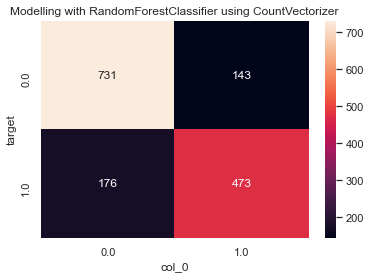

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       874
         1.0       0.77      0.73      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



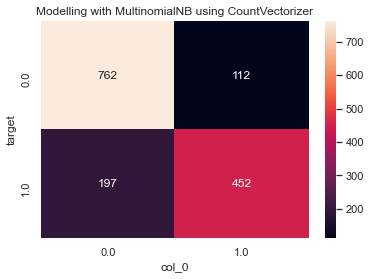

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83       874
         1.0       0.80      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



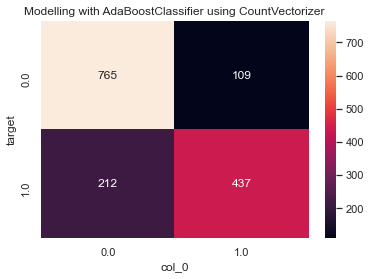

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       874
         1.0       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



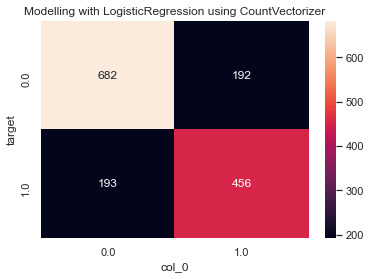

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       874
         1.0       0.70      0.70      0.70       649

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



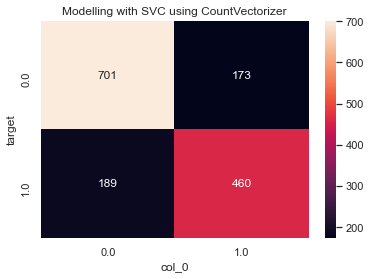

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79       874
         1.0       0.73      0.71      0.72       649

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



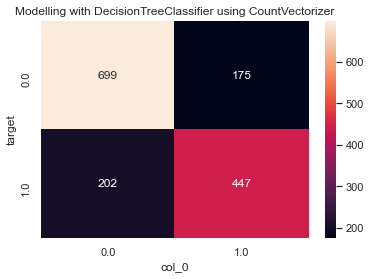

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       874
         1.0       0.72      0.69      0.70       649

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.75      0.75      1523



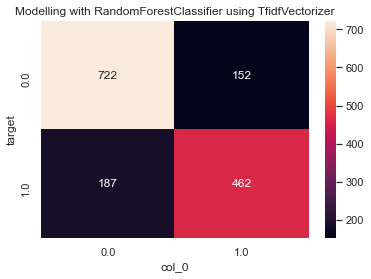

              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81       874
         1.0       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



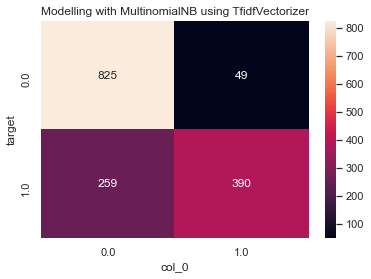

              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84       874
         1.0       0.89      0.60      0.72       649

    accuracy                           0.80      1523
   macro avg       0.82      0.77      0.78      1523
weighted avg       0.82      0.80      0.79      1523



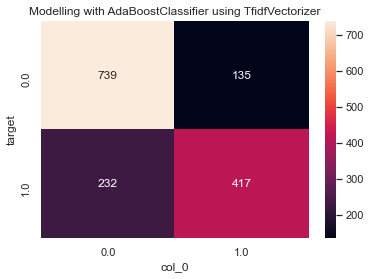

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       874
         1.0       0.76      0.64      0.69       649

    accuracy                           0.76      1523
   macro avg       0.76      0.74      0.75      1523
weighted avg       0.76      0.76      0.76      1523



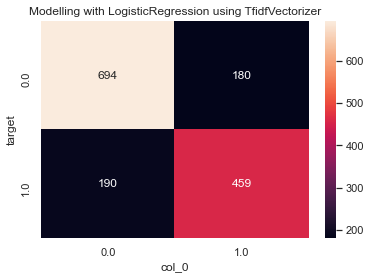

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       874
         1.0       0.72      0.71      0.71       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



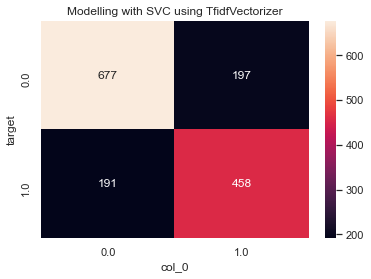

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78       874
         1.0       0.70      0.71      0.70       649

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



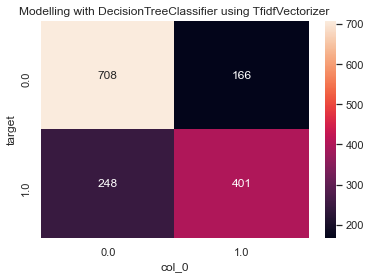

              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       874
         1.0       0.71      0.62      0.66       649

    accuracy                           0.73      1523
   macro avg       0.72      0.71      0.72      1523
weighted avg       0.73      0.73      0.73      1523



In [42]:
summary, predictions, tests, X_y_train_test = split_model_summarize(models, X_train, Y_train, test, vectorizers)

In [43]:
summary.sort_values(by='f1_score', ascending=False)

,model,vectorizer,f1_score,training_score,testing_score
0,RandomForestClassifier,CountVectorizer,74.782609,96.206897,0.790545
1,MultinomialNB,CountVectorizer,74.525969,84.958949,0.797111
6,RandomForestClassifier,TfidfVectorizer,73.159145,98.160920,0.777413
2,AdaBoostClassifier,CountVectorizer,73.138075,85.648604,0.789232
4,SVC,CountVectorizer,71.762871,98.522167,0.762311
7,MultinomialNB,TfidfVectorizer,71.691176,83.694581,0.797768
9,LogisticRegression,TfidfVectorizer,71.273292,97.783251,0.757058
5,DecisionTreeClassifier,CountVectorizer,70.338316,81.165846,0.752462
3,LogisticRegression,CountVectorizer,70.316114,98.243021,0.747209
10,SVC,TfidfVectorizer,70.245399,98.423645,0.745240


In [44]:
predictions.head()

,RandomForestClassifier_with_CountVectorizer,MultinomialNB_with_CountVectorizer,AdaBoostClassifier_with_CountVectorizer,LogisticRegression_with_CountVectorizer,SVC_with_CountVectorizer,DecisionTreeClassifier_with_CountVectorizer,RandomForestClassifier_with_TfidfVectorizer,MultinomialNB_with_TfidfVectorizer,AdaBoostClassifier_with_TfidfVectorizer,LogisticRegression_with_TfidfVectorizer,SVC_with_TfidfVectorizer,DecisionTreeClassifier_with_TfidfVectorizer
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,1,1,0
2,1,1,0,0,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,1,1,0


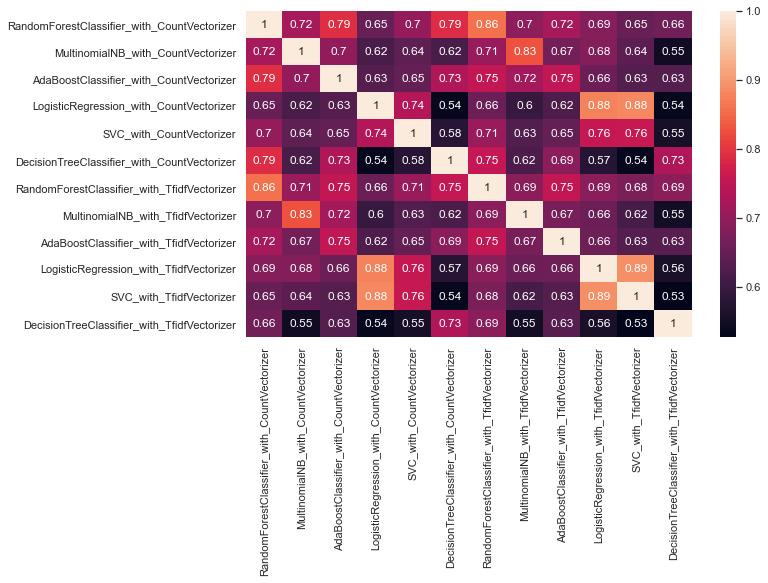

In [45]:
plt.figure(figsize=(10,6))
sns.heatmap(predictions.corr(), annot=True)
plt.show();

### Voting

In [46]:
forest_count = joblib.load("RandomForestClassifier_CountVectorizer.joblib")
forest_tfidf = joblib.load("RandomForestClassifier_TfidfVectorizer.joblib")
multi_count = joblib.load("MultinomialNB_CountVectorizer.joblib")
multi_tfidf = joblib.load("MultinomialNB_TfidfVectorizer.joblib")
adaboost_count = joblib.load("AdaBoostClassifier_CountVectorizer.joblib")
adaboost_tfidf = joblib.load("AdaBoostClassifier_TfidfVectorizer.joblib")
logistic_count = joblib.load("LogisticRegression_CountVectorizer.joblib")
logistic_tfidf = joblib.load("LogisticRegression_TfidfVectorizer.joblib")
svc_count = joblib.load("SVC_CountVectorizer.joblib")
svc_tfidf = joblib.load("SVC_TfidfVectorizer.joblib")
dectree_count = joblib.load("DecisionTreeClassifier_CountVectorizer.joblib")
dectree_tfidf = joblib.load("DecisionTreeClassifier_TfidfVectorizer.joblib")

In [47]:
vote_count = VotingClassifier([("Forest count",forest_count),
                               ("Multinomial count",multi_count),
                               ("AdaBoost count", adaboost_count),
                               ("logistic count", logistic_count),
                               ("SVM count", svc_count),
                               ("decTree count", dectree_count),
                               ("Forest tfidf",forest_tfidf),
                               ("Multinomial tfidf",multi_tfidf),
                               ("AdaBoost tfidf", adaboost_tfidf),
                               ("logistic tfidf", logistic_tfidf),
                               ("SVM tfidf", svc_tfidf),
                               ("decTree tfidf", dectree_tfidf)], voting='soft')

In [48]:
xtrain_count = X_y_train_test[0][1]
ytrain_count = X_y_train_test[0][2]

xtest_count = X_y_train_test[1][1]
ytest_count = X_y_train_test[1][2]


xtrain_tfidf = X_y_train_test[2][1]
ytrain_tfidf = X_y_train_test[2][2]

xtrain_tfidf = X_y_train_test[3][1]
ytrain_tfidf = X_y_train_test[3][2]

final_test_count = tests[0][1]
final_test_tfidf = tests[1][1]

In [49]:
xtrain_count.data

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [50]:
vote_count.fit(xtrain_count, ytrain_count)

VotingClassifier(estimators=[('Forest count',
                              RandomForestClassifier(min_samples_split=5,
                                                     n_estimators=150,
                                                     random_state=42)),
                             ('Multinomial count', MultinomialNB(alpha=5.0)),
                             ('AdaBoost count',
                              AdaBoostClassifier(learning_rate=0.6,
                                                 n_estimators=450,
                                                 random_state=42)),
                             ('logistic count',
                              LogisticRegression(C=50, max_iter=1000,
                                                 tol=0.001)),
                             ('SVM count',
                              SVC(C=100, degr...
                             ('Multinomial tfidf', MultinomialNB(alpha=5.0)),
                             ('AdaBoost tfidf',
          

In [51]:
predict = vote_count.predict(final_test_count)

In [52]:
sample = pd.read_csv("sample_submission.csv")

In [53]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [54]:
sample['target'] = predict.astype(int)

In [55]:
predict

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
Counter(sample.target)

Counter({1: 1201, 0: 2062})

In [57]:
sample

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### TensorFlow

In [58]:
# Importing the necessary packages
import os
import string


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Dense, GRU, Dropout, Activation, Dot,
                                     Input, Flatten, MaxPool1D, Bidirectional, Conv1D)
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import optimizers

from functools import reduce

In [59]:
%load_ext tensorboard

In [60]:
train = train[["cleaned_text", "target"]]

In [61]:
train.shape

(7613, 2)

In [62]:
train_labels = train.target
train = train.cleaned_text

In [63]:
test.shape

(3263,)

In [64]:
def count_total_words(text):
    count = Counter()
    for t in text.values:
        for word in t.split():
            count[word] +=1
    return len(count)

In [65]:
num_words = count_total_words(train)
num_words

17902

In [66]:
max_length = 20

In [67]:
xtrain, xtest, ytrain, ytest = train_test_split(train, train_labels, test_size=0.2, random_state=42)

In [68]:
# Tokenizing

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(xtrain)

In [69]:
word_index = tokenizer.word_index

In [70]:
xtrain = tokenizer.texts_to_sequences(xtrain)

xtest = tokenizer.texts_to_sequences(xtest)

xtrain[0]

[5700, 3744, 2277, 79, 347, 129, 50, 1933, 3745, 1027, 151, 3746, 3747]

In [71]:
test = tokenizer.texts_to_sequences(test)

test_padded = pad_sequences(test, maxlen=max_length, padding='post', truncating='post')

In [72]:
# Padding the sequences

xtrain_padded = pad_sequences(xtrain, maxlen=max_length, padding='post', truncating='post')

xtest_padded = pad_sequences(xtest, maxlen=max_length, padding='post', truncating='post')

In [73]:
tf_model = Sequential()

tf_model.add(Embedding(num_words, 32, input_length=max_length))
tf_model.add(LSTM(64, dropout=0.1))
tf_model.add(Dense(64, activation='relu'))
tf_model.add(Dense(1, activation='sigmoid'))

callbacks = EarlyStopping(monitor='val_loss', patience=3)
optimizer = Adam(learning_rate=0.0001)

tf_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [74]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            572864    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 601,921
Trainable params: 601,921
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = tf_model.fit(xtrain_padded, ytrain, epochs=20, 
                    validation_data=(xtest_padded, ytest), callbacks=callbacks)

Epoch 1/20
191/191 [==============================] - 4s 23ms/step - loss: 0.6859 - accuracy: 0.5695 - val_loss: 0.6764 - val_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 4s 18ms/step - loss: 0.6225 - accuracy: 0.6392 - val_loss: 0.5188 - val_accuracy: 0.7636
Epoch 3/20
191/191 [==============================] - 4s 19ms/step - loss: 0.3863 - accuracy: 0.8353 - val_loss: 0.4758 - val_accuracy: 0.7774
Epoch 4/20
191/191 [==============================] - 4s 19ms/step - loss: 0.2932 - accuracy: 0.8824 - val_loss: 0.5087 - val_accuracy: 0.7833
Epoch 5/20
191/191 [==============================] - 4s 19ms/step - loss: 0.2301 - accuracy: 0.9112 - val_loss: 0.5546 - val_accuracy: 0.7833
Epoch 6/20
191/191 [==============================] - 4s 19ms/step - loss: 0.1774 - accuracy: 0.9355 - val_loss: 0.6191 - val_accuracy: 0.7787


In [76]:
y_predict = tf_model.predict(test_padded)

In [77]:
y_predict_df = pd.DataFrame(data=y_predict, columns=['tensorflow'])

In [78]:
y_predict_df = y_predict_df['tensorflow'].map( lambda x: 0 if x < 0.4 else 1)

In [79]:
Counter(y_predict_df)

Counter({1: 1333, 0: 1930})

In [80]:
sample['target'] = y_predict_df.astype(int)
sample

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### PyTorch

In [81]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

In [82]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()

In [83]:
for text in X_train:
    counter.update(tokenizer(text))
vocab = Vocab(counter, min_freq=1)

In [84]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x)

In [85]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
data = []
for y, x in zip(Y_train, X_train):
    data.append((y, x))

In [87]:
train_iter, test_iter = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [88]:
def collate_batch(batch):
    label_list, text_list, offsets = [],[],[0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    #offsets = torch.tensor(offsets[:-1].cumsum(dim=0))
    offsets = torch.tensor(np.cumsum(offsets[:-1]), dtype=torch.long)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [89]:
from torch import nn

class TextClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [90]:
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
torch_model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [91]:
import time

def train(dataloader):
    torch_model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = torch_model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(torch_model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {}  | {}/{} batches| accuracy {}'.format(
                epoch, idx, len(dataloader), total_acc/total_count))
            
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    torch_model.eval()
    total_acc, total_count = 0, 0
    
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = torch_model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [92]:
from torch.utils.data.dataset import random_split

# Hyperparameters
EPOCHS = 20
LR = 5
BATCH_SIZE = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_dataset = list(train_iter)
test_dataset = list(test_iter)
num_train = int(len(train_dataset)*0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train]) 

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None  and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    
    print('='*80)
    print("| End of Epoch {}| time: {} | valid accuracy: {}".format(epoch, (time.time()- epoch_start_time), accu_val))
    print("="*80)

| End of Epoch 1| time: 1.009831428527832 | valid accuracy: 0.6721311475409836
| End of Epoch 2| time: 0.5665349960327148 | valid accuracy: 0.7344262295081967
| End of Epoch 3| time: 0.5562784671783447 | valid accuracy: 0.7475409836065574
| End of Epoch 4| time: 0.5594577789306641 | valid accuracy: 0.7442622950819672
| End of Epoch 5| time: 0.5624113082885742 | valid accuracy: 0.7475409836065574
| End of Epoch 6| time: 0.5550577640533447 | valid accuracy: 0.7508196721311475
| End of Epoch 7| time: 0.5545108318328857 | valid accuracy: 0.7377049180327869
| End of Epoch 8| time: 0.5798637866973877 | valid accuracy: 0.7377049180327869
| End of Epoch 9| time: 0.5532927513122559 | valid accuracy: 0.7377049180327869
| End of Epoch 10| time: 0.5652446746826172 | valid accuracy: 0.7377049180327869
| End of Epoch 11| time: 0.5594205856323242 | valid accuracy: 0.7377049180327869
| End of Epoch 12| time: 0.5708534717559814 | valid accuracy: 0.7377049180327869
| End of Epoch 13| time: 0.57208776473

In [93]:
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

test accuracy    0.701


In [94]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.long)
        output = torch_model(text, torch.tensor([0]))
        return output.argmax(1).item()

In [95]:
test_trial = []
for t in test_final:
    test_trial.append(t)

In [96]:
pred = []
for t in test_trial:
    torch_model = torch_model.to("cpu")
    torch_predict = predict(t, text_pipeline)
    pred.append(torch_predict)

In [97]:
len(pred)

3263

In [98]:
sample['target'] = pred

In [99]:
sample

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [100]:
sample.to_csv("torch_predict.csv", index=False)

In [101]:
tf_result = pd.read_csv("tensorflow_pred.csv")

<AxesSubplot:>

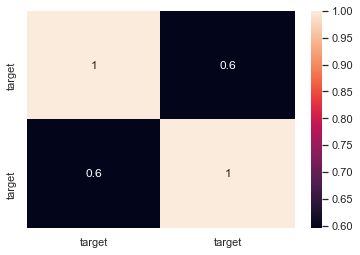

In [102]:
sns.heatmap(pd.concat([tf_result['target'], sample['target']], axis=1).corr(), annot=True)

### Final Vote 

In [161]:
model_names = list(predictions.columns)

#for mod_name in ['tensorflow_model', 'torch_model']:
#    model_names.append(mod_name)


def predict_final(models, model_names, test):    
    matrix = []
    
    for model in models:
        pred = model.predict(test)
        matrix.append(pred.astype(int))
    final_predictions = pd.DataFrame(data = np.transpose(matrix),columns=model_names)
    
    
    return final_predictions

In [118]:
final_models =[forest_count, forest_tfidf, multi_count, multi_tfidf, adaboost_count, adaboost_tfidf,
               logistic_count, logistic_tfidf, svc_count, svc_tfidf, dectree_count, dectree_tfidf]

In [119]:
final_pred = predict_final(final_models, model_names, final_test_count)

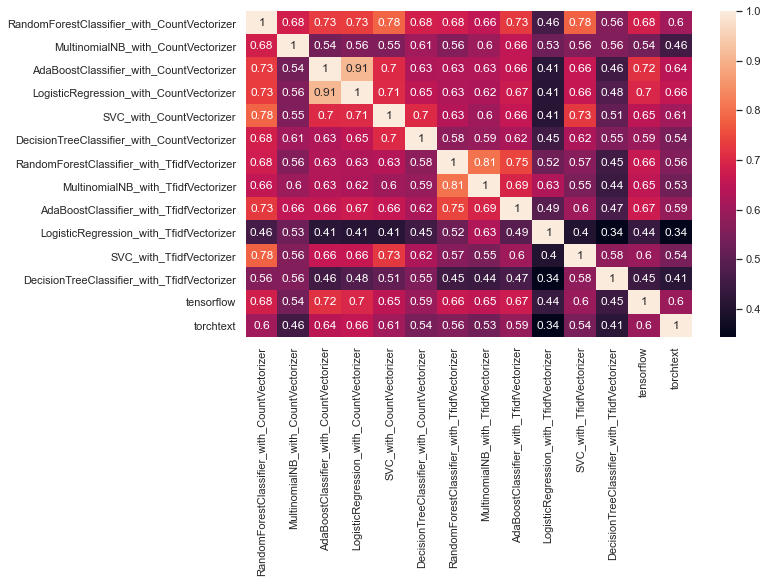

In [121]:
final_pred['tensorflow'] = tf_result['target']
final_pred['torchtext'] = sample['target']

plt.figure(figsize=(10,6))
sns.heatmap(final_pred.corr(), annot=True)
plt.show();

In [122]:
final_pred.isnull().sum()

RandomForestClassifier_with_CountVectorizer    0
MultinomialNB_with_CountVectorizer             0
AdaBoostClassifier_with_CountVectorizer        0
LogisticRegression_with_CountVectorizer        0
SVC_with_CountVectorizer                       0
DecisionTreeClassifier_with_CountVectorizer    0
RandomForestClassifier_with_TfidfVectorizer    0
MultinomialNB_with_TfidfVectorizer             0
AdaBoostClassifier_with_TfidfVectorizer        0
LogisticRegression_with_TfidfVectorizer        0
SVC_with_TfidfVectorizer                       0
DecisionTreeClassifier_with_TfidfVectorizer    0
tensorflow                                     0
torchtext                                      0
dtype: int64

In [126]:
final_pred['average'] = final_pred.apply(np.mean, axis=1)

In [127]:
final_pred.iloc[:,-1]

0       0.928571
1       0.928571
2       1.000000
3       0.714286
4       1.000000
          ...   
3258    1.000000
3259    0.785714
3260    1.000000
3261    0.642857
3262    0.642857
Name: average, Length: 3263, dtype: float64

In [158]:
submission = sample

submission['target'] = final_pred['average'].apply(lambda x: 0 if x <= 0.5 else 1).astype(int)

In [159]:
Counter(submission['target'])

Counter({1: 1208, 0: 2055})

In [160]:
submission.to_csv("final_submission.csv", index=False)

The "final_submission.csv" file was submitted to Kaggle and it yielded an accuracy of 79.834% 

In [162]:
#### END OF PROJECT ####